In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split, StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.decomposition import PCA

from path import Path
import warnings 
warnings.filterwarnings('ignore') # supress warnings

In [2]:
# %% [code]
# Here some commoly used funcitons and class by me for regression problems

from sklearn.model_selection import KFold, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay, auc

class Splitter:
    """A splitter class which splits the X, y using the split_data function with a random state provided. It yeilds \
    X_train, X_val, y_train, y_val, train_idx, val_idx in the end.\
    code from  https://www.kaggle.com/code/tetsutani/ps3e9-eda-and-gbdt-catboost-median-duplicatedata wit little bit of modification """

    def __init__(self, test_size=0.2, kfold=True, n_splits=5):
        self.test_size = test_size # set test size
        self.kfold = kfold  # wheter to just split the data in two or use kfold
        self.n_splits= n_splits # set 
        
    def split_data(self, X, y, random_state):
        if self.kfold:
            kf = KFold(n_splits=self.n_splits, random_state=random_state, shuffle=True)
            for train_idx, val_idx in kf.split(X, y):
                X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
                y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
                yield X_train, X_val, y_train, y_val, train_idx, val_idx
        else:
            X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=self.test_size, random_state=random_state)
            yield X_train, X_val, y_train, y_val



# summarized dataset.
def summary(_df):
    """A function which summarizes the dataset given by giving us various statistical information"""
    summ = pd.DataFrame(_df.dtypes, columns=['data type'])
    summ['missing'] = _df.isnull().sum()
    summ['%missing'] = summ['missing'] / len(_df)
    summ['no_of_unique'] = _df.nunique()
    
    desc = _df.describe(include='all').transpose()
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['mean'] = desc['mean'].values
    summ['median'] = desc['50%'].values
    summ['first_value'] = _df.loc[0].values.flatten()
    summ['second_value'] = _df.loc[1].values.flatten()
    summ['third_value'] = _df.loc[2].values.flatten()
    
    return summ




def evaluate_model(model_name, model_pipeline, _X, _y, features, original_data=None, use_original=False, n_splits=5, random_state_list=[0, 5, 10], verbose=True):
    len_y = len(_y)
    len_states = len(random_state_list)

    oof_preds = np.zeros(len_y * len_states).reshape(len_states, len_y)
    models_pipeline = []
    scores_train = []

    for index, random_state in enumerate(random_state_list):
        if verbose:
            print("#"*25)
            print("#"*15, f"traininng model {model_name} with seed {random_state}")
            print("#"*25)
        splitter = Splitter(n_splits=n_splits)
        splits = 0
        for X_train, X_val, y_train, y_val, train_idx, val_idx in splitter.split_data(_X, _y, random_state):
    
            
            if use_original: # we will only use original data for training not testing
                target = 'cost'
                X_train = pd.concat([X_train, original_data.drop(target, axis=1)]) 
                y_train = pd.concat([y_train, np.log(original_data[target])]) # only for 

#             model_pipeline.fit(X_train, y_train, model__eval_set=[(X_val, y_val)], model__verbose=False)
            model_pipeline.fit(X_train, y_train)
            oof_preds[index, val_idx] = model_pipeline.predict(X_val).squeeze()
            models_pipeline.append(deepcopy(model_pipeline))

            score_train = mean_squared_log_error(y_train, model_pipeline.predict(X_train))
            scores_train.append(score_train)

            score_valid_split = mean_squared_log_error(y_val, model_pipeline.predict(X_val).squeeze())
            splits += 1
            if verbose:
                print(f"seed {random_state} and split {splits} score {score_valid_split}")

            
    oof_preds_mean = oof_preds.mean(axis=0)

    return models_pipeline, oof_preds_mean, np.mean(scores_train), mean_squared_log_error(_y, oof_preds.mean(axis=0))


def predict_test(models_pipeline, X_test, n_splits=5, n_repeats=3):
    test_preds = np.zeros(n_splits * n_repeats * len(X_test)).reshape(n_splits * n_repeats, len(X_test))
    
    for index, model_pipeline in enumerate(models_pipeline):
        X_test_ = X_test.copy()
        preds = model_pipeline .predict(X_test_)                
        test_preds[index, range(len(preds))] = preds
        
    return test_preds.mean(axis=0)


 
# plot pca
def plot_pca(df):
    """Takes a dataset and do pricinpal component analysis and plots the results. Do not pass target"""
    #     The code below is mostly taken from kaggle learn course Principal Component Analysis. Link is below
    # https://www.kaggle.com/code/ryanholbrook/principal-component-analysis#Example---1985-Automobiles
    _X = df.copy()
    features = _X.columns.tolist()

    # Standardize
    X_scaled = (_X - _X.mean(axis=0)) / _X.std(axis=0)
    
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)

    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)

    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=_X.columns,  # and the rows are the original features
    )
    
    display(loadings)
    plot_variance(pca)
    
    return X_pca

# helper function of plot_pca
def plot_variance(pca, width=8, dpi=100):
    """"plot pca vairance given the pca object provided where the dataset is already passed"""
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=12, dpi=100)
    return axs

    
# plot categorical features  
def plot_categorical(df, x=None, y=None, violin=False, title="Count plot", legend=None, **kwargs):
    "Takes in a pandas dataframe and plot countplot if y is not given and a violin plot if y is also given"
    if y:
        if violin:
            ax = sns.violinplot(data=df, x=x, y=y, **kwargs) # plots violinplot if y is given
        else:
            ax = sns.boxplot(data=df, x=x, y=y, **kwargs)
    else:
        ax = sns.countplot(data=df, x=x, **kwargs)       # plot countplot if y is not given
        
    ax.set_title(title) # sets title
    if legend: # sets custom legend if given
        ax.legend(labels=[legend])

#  plot correaltion        
def plot_corr(df, features, target, sort=False, method='pearson', figsize=(13, 8), use_mask=True, mask_type="triu", **kwargs):
    """Plot correlation given dataset and features names"""
    plt.figure(figsize=figsize) # sets figure size
    corr = df[features].corr(method=method) # calculates correlation based on the features and method provied
    target_values = corr[target]
    features.remove(target)
    corr = corr[features]
    
    corr = pd.concat([corr, target_values], axis=1)
    
    if sort: # if sort is true then sort the correlation matrix
        corr = corr.sort_values(by=target)
    if use_mask: # if uses_mask = True
        if mask_type == 'triu': # sets mask type to lower trigonal
            mask = np.triu(np.ones(corr.shape)) 
        else:   # sets mask type to upper trigonal
            mask = np.tril(np.ones(corr.shape))
        sns.heatmap(corr, annot=True, mask=mask, **kwargs)
        
    else: # if uses mask is not true
         sns.heatmap(corr, annot=True, **kwargs)       

    plt.title('Correlation between features')
  


# DATASET DESCRIPTION

* <b>specific gravity:</b> the density of the urine relative to water;
* <b>pH:</b> the negative logarithm of the hydrogen ion; 
* <b>osmolarity (mOsm):</b> a unit used in biology and medicine but not in physical chemistry. Osmolarity is proportional to the concentration of molecules in solution; 
* <b>conductivity (mMho milliMho):</b> One Mho is one reciprocal Ohm. Conductivity is proportional to the concentration of charged ions in solution; 
* <b>urea</b> concentration in millimoles per litre;
* <b>calcium:</b> concentration (CALC) in millimolesllitre.

In [3]:
# loading datasets
path = Path("/kaggle/input/playground-series-s3e12")

train = pd.read_csv(path / "train.csv")
test = pd.read_csv(path / "test.csv")
sub = pd.read_csv(path / "sample_submission.csv")
original = pd.read_csv("/kaggle/input/kidney-stone-prediction-based-on-urine-analysis/kindey stone urine analysis.csv")
original = original[train.drop('id', axis=1).columns.tolist()]

train.head()

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0
3,3,1.021,4.91,442,20.8,398,6.63,1
4,4,1.021,5.53,874,17.8,385,2.21,1


# DATASET OVERVIEW

In [4]:
# overall shapes
print(f"Training set has {train.shape[0]} rows and {train.shape[1]} cols")
print(f"Test set has {test.shape[0]} rows and {test.shape[1]} cols")
print(f"original set has {original.shape[0]} rows and {original.shape[1]} cols")

Training set has 414 rows and 8 cols
Test set has 276 rows and 7 cols
original set has 79 rows and 7 cols


In [5]:
# number of nulls in train and test set
null_train = train.isnull().sum().sum()
null_test = test.isnull().sum().sum()
null_original = original.isnull().sum().sum()

print(f"Number of nulls in train: {null_train}")
print(f"Number of nulls in test: {null_test}")
print(f"Number of nulls in original: {null_original}")

Number of nulls in train: 0
Number of nulls in test: 0
Number of nulls in original: 0


In [6]:
train_dtypes = train.dtypes.value_counts()
test_dtypes = test.dtypes.value_counts()
original_dtypes = original.dtypes.value_counts()

print("Training dataset: ", end='\n\n')
display(train_dtypes)
print("Test dataset: ", end='\n\n')
display(test_dtypes)
print('Original dataset: ', end='\n\n')
display(original_dtypes)

Training dataset: 



int64      4
float64    4
dtype: int64

Test dataset: 



float64    4
int64      3
dtype: int64

Original dataset: 



float64    4
int64      3
dtype: int64

In [7]:
train_dup = train.drop(['target', 'id'], axis=1).duplicated().sum()
test_dup = test.drop("id", axis=1).duplicated().sum()
original_dup = original.drop("target", axis=1).duplicated().sum()


print(f"duplicates in train :{train_dup},  test :{test_dup} and original: {original_dup}")

duplicates in train :0,  test :0 and original: 0


In [8]:
train_summary = summary(train)
train_summary

,data type,missing,%missing,no_of_unique,min,max,mean,median,first_value,second_value,third_value
id,int64,0,0.0,414,0.000,413.00,206.500000,206.500,0.000,1.000,2.000
gravity,float64,0,0.0,28,1.005,1.04,1.017894,1.018,1.013,1.025,1.009
ph,float64,0,0.0,71,4.760,7.94,5.955459,5.740,6.190,5.400,6.130
osmo,int64,0,0.0,80,187.000,1236.00,651.545894,679.500,443.000,703.000,371.000
cond,float64,0,0.0,65,5.100,38.00,21.437923,22.200,14.800,23.600,24.500
urea,int64,0,0.0,73,10.000,620.00,278.657005,277.000,124.000,394.000,159.000
calc,float64,0,0.0,85,0.170,14.34,4.114638,3.130,1.450,4.180,9.040
target,int64,0,0.0,2,0.000,1.00,0.444444,0.000,0.000,0.000,0.000


# EDA

Before doing anything we should check if distributions in original is the same as our train and test dataset for that we will use ****Adversarial Validation**** technique.

In [9]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression

In [10]:
# plot adversarial_validations scores for each splits
def adversarial_validation(train_df, test_df, classifier, n_splits=5, title='Roc curve', figsize=(6, 6)):
    """This is a function which checks if distribution between two datasets are same given the same columns. Then plots roc curve\
for each split. A score close to 0.5 means very similar(Do not provide the target feature)"""
    
    train_df['target'] = 1  
    test_df['target'] = 0
    

#     if len(train_df) > len(test_df):
#         size = len(test_df)
#     else:
#         size = len(train_df)
    
#     train_df = train_df.sample(size)
#     test_df = test_df.sample(size)

#     test_df = test_df.sample(n=len(train_df), replace=True)
    
    df = pd.concat([train_df, test_df]).sample(frac=1)
    
    X = df.drop('target', axis=1)
    y = df['target']
    
    cv = LeaveOneOut()

    preds_prob = []
    y_true = []
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        classifier.fit(X.iloc[train_idx], y.iloc[train_idx])
        pred_prob = classifier.predict_proba(X.iloc[val_idx])
        preds_prob.append(pred_prob[0][1])
        y_true.append(y.iloc[val_idx].values[0])
        
    
    auc_score = roc_auc_score(y_true, preds_prob)

    fpr, tpr, _ = roc_curve(y_true, preds_prob)
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(fpr, tpr, marker='.', label='LGBMClassifier')
    ax.text(0.05, 0.95, f"auc score: {auc_score}", bbox={'boxstyle':"round"})
    ax.set_title(title);

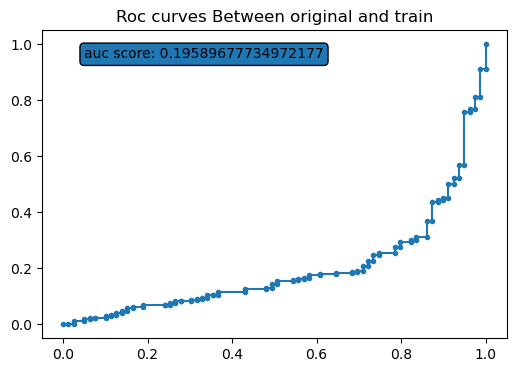

In [11]:
cols = train.drop(['id', 'target'], axis=1).columns
adversarial_validation(train[cols], original[cols], LGBMClassifier(), title='Roc curves Between original and train', figsize=(6, 4))

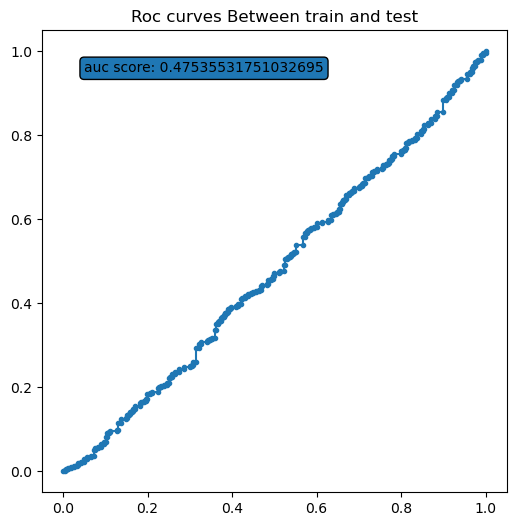

In [12]:
cols = train.drop(['id', 'target'], axis=1).columns
adversarial_validation(train[cols], test[cols], LGBMClassifier(), title='Roc curves Between train and test')

Right now it is kinda hard to tell how much similar original is to train since we so little of original data. But score are generally very low. So it's probably won't be good to include it in our model

# EDA

## Target Distribution

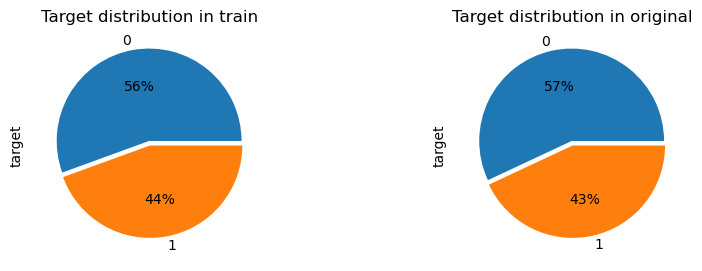

In [13]:
train_target_dist = train['target'].value_counts()
original_target_dist = original['target'].value_counts()

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
ax1 = train_target_dist.plot(kind='pie', autopct='%1.0f%%', explode=[0.05, 0])
ax1.set_title("Target distribution in train")

plt.subplot(1, 2, 2)
ax2 = original_target_dist.plot(kind='pie', autopct='%1.0f%%', explode=[0.05, 0])
ax2.set_title("Target distribution in original");

The distribution of target is same

## Histogram

In [14]:
# plot histogram    
def plot_hist(df, x, x_label=None, title='Distribution', legend=None, **kwargs):
    '''Takes in a pandas dataframe and plot a histogram based on the feature name x provided'''
    ax = sns.histplot(data=df, x=x, alpha=0.3, **kwargs)
    ax2 = ax.twinx()
    ax2 = sns.boxplot(data=df, x=x, ax=ax2, color='orange')
    ax2.set(ylim=(-.5, 10))
    ax.axvline(x=df[x].median(), color='red', linestyle='dashed')
    
    if x_label: # set custom feature names if given
        ax.set_xlabel(x_label)
    if legend: # set custom legends if given a values
        ax.legend(labels=[legend, 'Median'])
        
    ax.set_title(title) # sets the title of the plot

In [15]:
con_feats = train.select_dtypes(include='float').columns.tolist() 
discrete_feats = train.drop(['id', 'target'], axis=1).select_dtypes('int').columns.tolist()

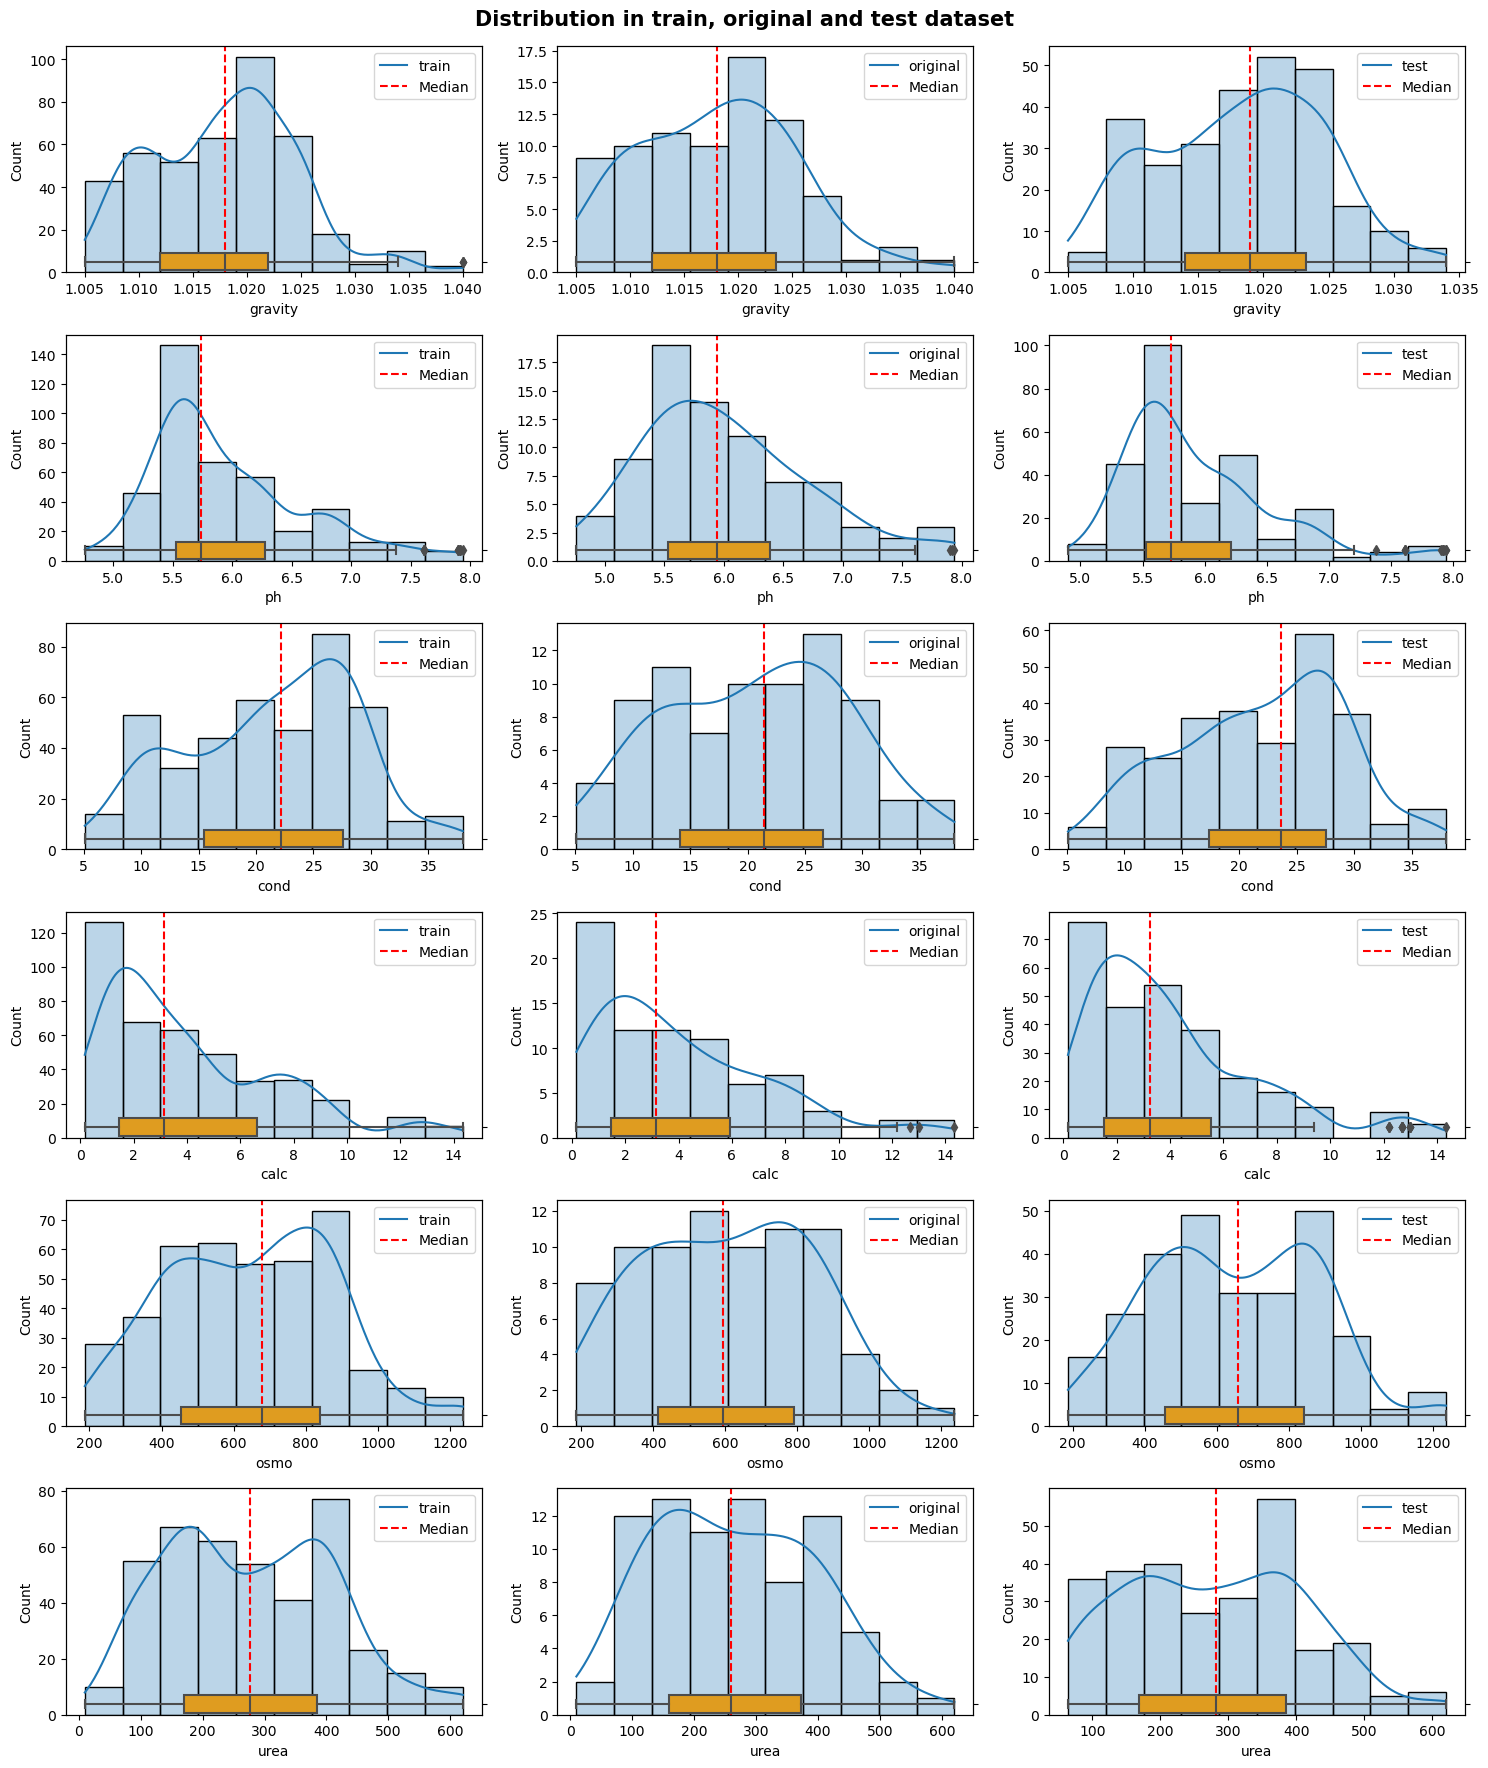

In [16]:
def get_nbins(df):
    return int(np.ceil(np.log2(len(train)) + 1))

nrows = len(con_feats + discrete_feats)
ncols = 3

train_nbins = get_nbins(train)
test_nbins = get_nbins(test)
original_nbins = get_nbins(original)

fig, ax = plt.subplots(nrows, ncols, figsize=(15, 3*nrows))

for i, feat in enumerate(con_feats+discrete_feats):
    plot_hist(train, feat, legend='train', title=None, ax=ax[i][0], kde=True, bins=train_nbins)
    plot_hist(original, feat, legend='original', title=None, ax=ax[i][1], kde=True, bins=original_nbins)
    plot_hist(test, feat, legend='test', title=None, ax=ax[i][2], kde=True, bins=test_nbins)
    

fig.suptitle("Distribution in train, original and test dataset\n", fontsize=15, fontweight='bold')    
plt.tight_layout()

## Line Plot

In [17]:
# plot line plot
def plot_line(df, x=None, y=None, title="Line plot", legend=None, **kwargs):
    "Takes in a pandas dataframe and plot a line plot for given x and y"
    ax = sns.lineplot(data=df, x=x, y=y, **kwargs)
    ax.set_title(title) # sets title
    if legend: # set custom legend if provided
        ax.legend(labels=[legend])

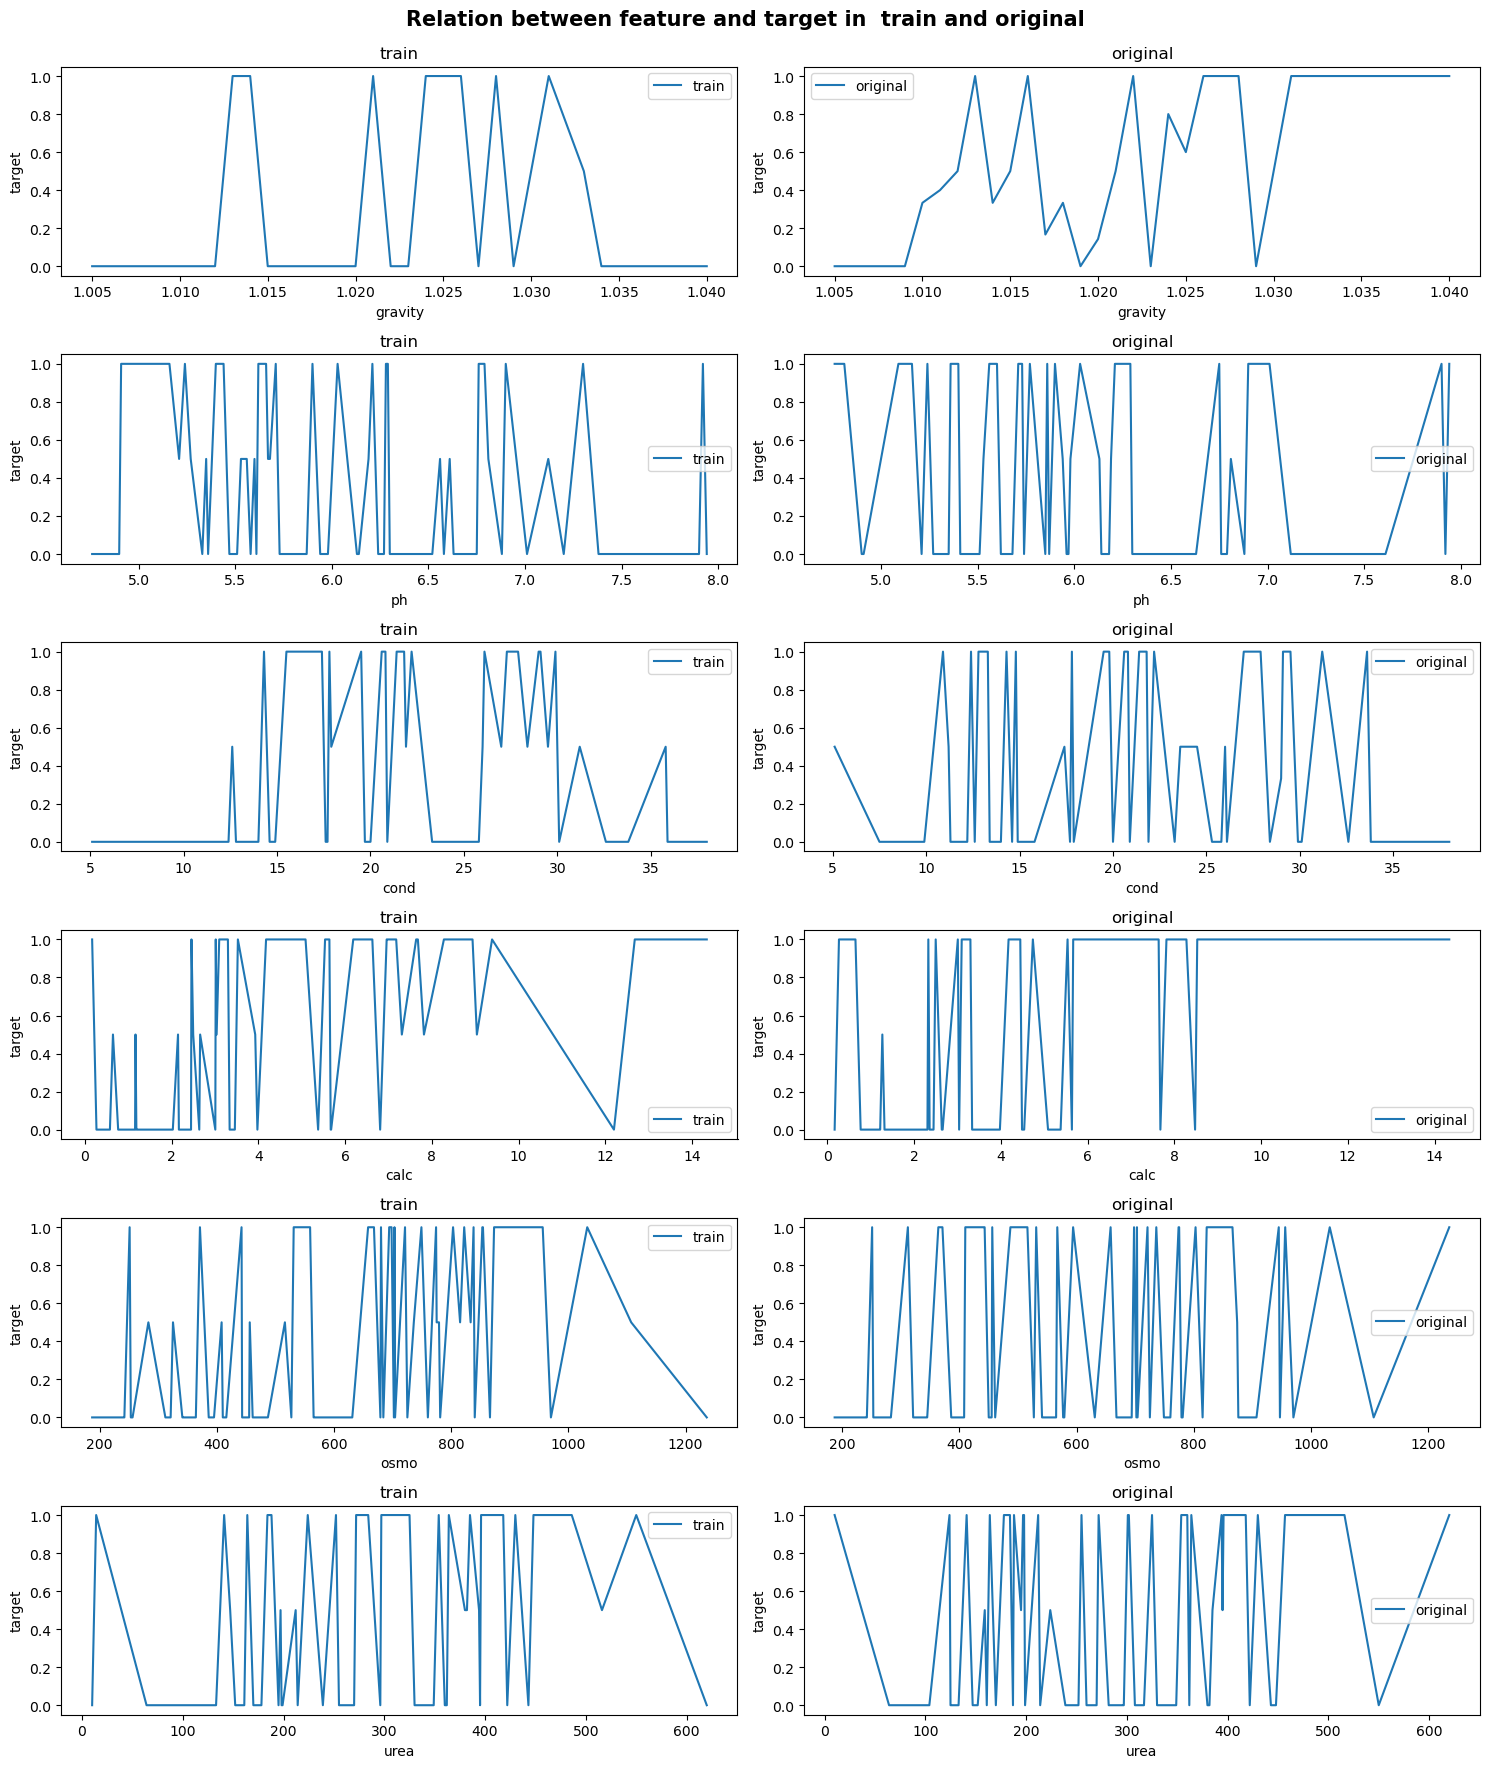

In [18]:
target = 'target'
nrows = len(discrete_feats+con_feats)
ncols = 2

fig, ax = plt.subplots(nrows, ncols, figsize=(15, 3*nrows))

for i, feat in enumerate(con_feats+discrete_feats):
    agg_train = train.groupby(feat)[target].median().reset_index()
    agg_org = original.groupby(feat)[target].mean().reset_index()
    plot_line(agg_train, x=feat, y=target, legend='train', title='train', ax=ax[i][0])
    plot_line(agg_org, x=feat, y=target, legend='original', title='original', ax=ax[i][1])
    

fig.suptitle("Relation between feature and target in  train and original\n", fontsize=15, fontweight='bold')    
plt.tight_layout()

## Box plot

In [19]:
# plot box plot  
def plot_box(df, x, x_label=None, title='Box plot', legend=None, **kwargs):
    '''Takes in a pandas dataframe and plot a boxplot on the feature name x provided'''
    ax = sns.boxplot(data=df, x=x, **kwargs)
    
    if x_label: # set custom feature names if given
        ax.set_xlabel(x_label)
    if legend:  # set custom legends if given a values
        ax.legend(labels=[legend])
        
    ax.set_title(title) # sets the title of the plot

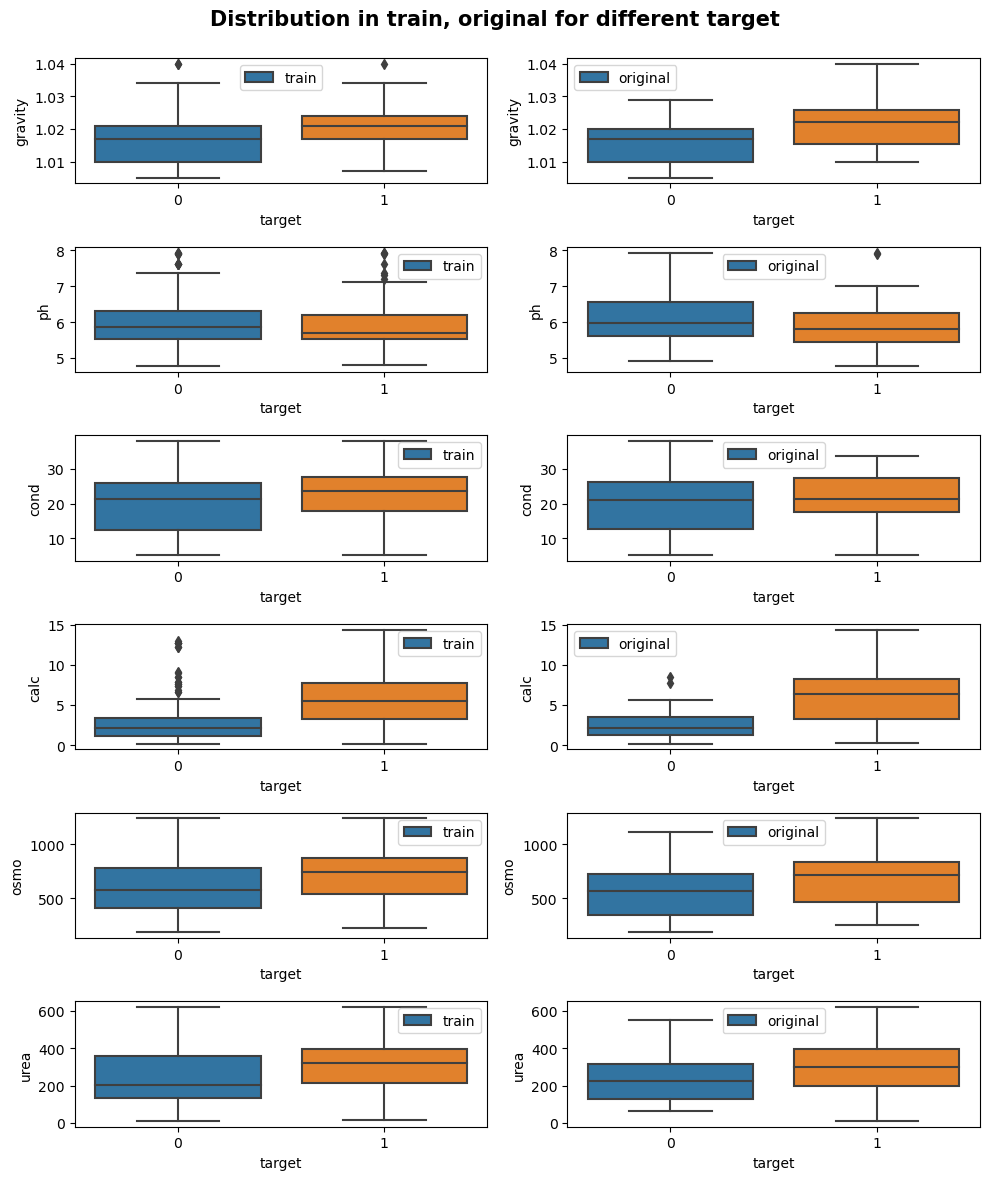

In [20]:
nrows = len(con_feats + discrete_feats)
ncols = 2
fig, ax = plt.subplots(nrows, ncols, figsize=(10, 2*nrows))

for i, feat in enumerate(con_feats+discrete_feats):
    plot_box(train, y=feat, x=target, legend='train', title=None, ax=ax[i][0])
    plot_box(original, y=feat, x=target, legend='original', title=None, ax=ax[i][1])
    
    
fig.suptitle("Distribution in train, original for different target\n", fontsize=15, fontweight='bold')    
plt.tight_layout()

## Correlation

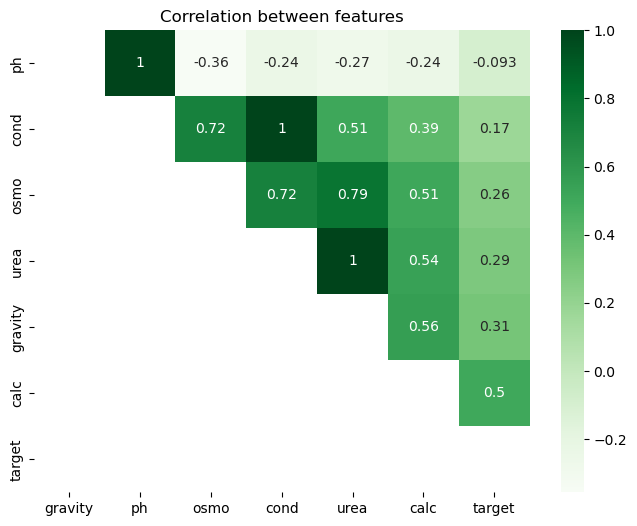

In [21]:
features = train.drop('id', axis=1).columns.tolist()
plot_corr(train, features=features, target='target', sort=True, method='spearman', use_mask=True, mask_type='tril', 
          figsize=(8, 6), cmap='Greens')

## PCA

,PC1,PC2,PC3,PC4,PC5,PC6
gravity,0.442919,0.020657,0.142341,0.434742,0.760286,0.126882
ph,-0.233902,0.949783,0.171692,0.112552,0.018421,-0.026757
osmo,0.498781,0.129866,-0.214444,0.106584,-0.180947,-0.802660
cond,0.395969,0.270445,-0.524900,-0.609574,0.156431,0.313843
urea,0.464560,0.086440,0.018543,0.422041,-0.599375,0.488876
calc,0.357381,0.002765,0.792723,-0.487107,-0.071855,-0.037746


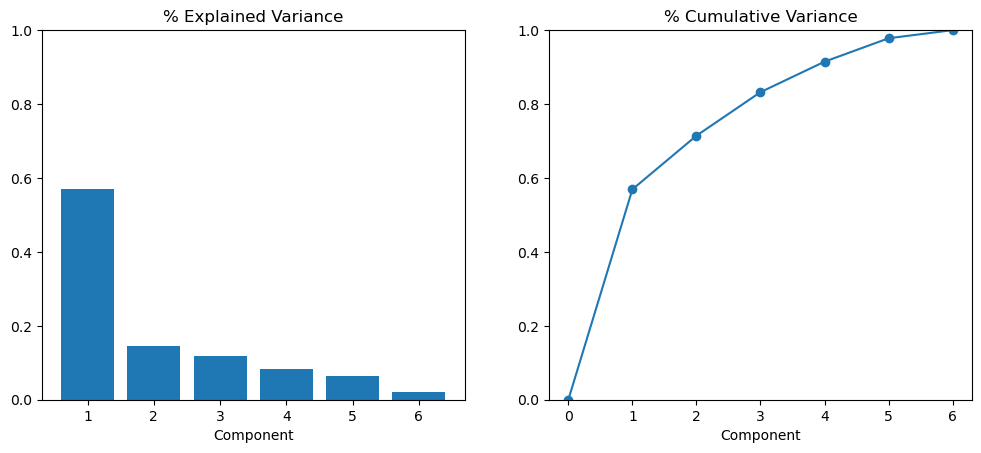

In [22]:
X_pca = plot_pca(train.drop(columns=['id', 'target']))